# Project 1: Pose Graph Optimization (scratch + g2o)
TEAM-ID: 1    
TEAM-NAME: curiosity
YOUR-ID: 1     
YOUR-NAME: Gowri Lekshmy             

(Although you work in groups, both the students have to submit to Moodle, hence there's name field above)

### Submission
Zip a folder of the following:
1. Files that you were provided with: `Project-1.ipynb`, the folders `misc` and `dataset`. Rest of the files asked in the questions below must be generated when i run the code. If generation of any file is computationally intensive, add `filename_backup.extension` where `filename.extension` is the expected name of file when i run the code. (For example, next point.)
2. Add `opt_backup.g2o` (described below) in outermost directory. Here, `opt.g2o` is the expected name of the file when I run the code.
3. For images of any results (like plots), save it in `./misc` folder.

On Moodle, all you have to submit is the jupyter notebook. But make sure to call the necessary functions explicitly (as specified in the notebook). The name of the zipped file being submitted to Moodle Assignment portal MUST BE `ID_Teamname_Firstname`. More details [here](https://www.notion.so/saishubodh/Course-Information-4c9e487b118547b2ba91d24e0dcaf04e#f2707a04f2a0446bac77763b47ba4bac).

On GitHub classrooms, the latest commit before the deadline will be considered as the submission. 

The deadline is Oct 16, 23:55 IST. Please get started ASAP, there is no way you can finish this project during the last few days before the deadline.

### General instructions

This ipython notebook (`.ipynb`) on GitHub is self-sufficient and has all the information you need to get started with the assignment, you don't need any corresponding PDF doc. Just fire up the notebook and get going!

General information like installation instructions in supplementary notebook "Project-1_Code-Walkthrough". Please take a look at it before you start this assignment.

Whenever I mention some `func()` below, I am referring to the "helper functions" in another supplementary notebook "Project-1_Code-Walkthrough" provided to you. Whenever I ask you to insert image below, it is better to save the image in `misc` and load it using `![file_name](file_location)` instead of directly pasting.    

[[CP-]] refers to CheckPoint, you have to ensure you do the tasks at each of the [[CP-]] places below. Not ensuring [[CP-B]] (CheckPoint-Basic) will incur heavy penalty and potentially 0 for that sub-section, and [[CP-M]] (CheckPoint-Marks) has a particular mark weightage depending on your results at that particular CP.

If you face any issues related to coding/installation, please raise an [issue here](https://github.com/Shubodh/MR-project1-pgo/issues). For any conceptual doubts, you can ask on Moodle or Teams as usual.

# 0. Introduction

In this project, we are going to use a non-linear weighted least squares optimization approach to solve the problem of getting a better estimate of our robot's trajectory. Least squares formulations are widely used for optimization, be it computer vision or robotics or machine learning. We will dive deep into it during this project and you will have complete clarity on optimization for vector-valued residual functions. 

In this "Introduction" section, I am going to provide an introduction for SLAM problem for a robot operating in the 2D world. It is 2. section in this Project. The 1D SLAM problem (1.) is far much simpler to understand and will be described directly in the 1. section. 

In a 2D world, a robot has 3 degrees of freedom, i.e. its pose in the world can be expressed by the state vector $\mathbf{x}=(x, y, \theta)^{\mathrm{T}}$. For the scope of this project, we are interested only in the robot's trajectory through the $2 \mathrm{D}$ world, and NOT in distinct landmarks or the surronding map of the environment, i.e. we are only interested in "L"ocalization part of SLAM. 

Therefore, we can represent it as a graph where the vertices represent robot poses $\mathbf{x}_{i}$ and edges represent the spatial constraints between these poses. Such a map is generally called a pose graph.

Two different kinds of constraints are necessary for pose graph SLAM. The first are
odometric constraints that connect two successive states $\mathbf{x}_{i}$ and $\mathbf{x}_{i+1}$ via a motion model. Furthermore, in order to perform loop closing, the robot has to recognize places it already visited before. This place recognition is also a part of the front-end and provides the second type of constraint, the loop closure constraints. These constraints connect two not necessarily successive poses $\mathbf{x}_{i}$ and $\mathbf{x}_{j}$.


![SLAM-trajectory-lc.png](misc/SLAM-trajectory-lc.png)   ![SLAM-trajectory-robust.png](misc/SLAM-trajectory-robust.png) (Source: [Sunderhauf 2012](https://core.ac.uk/download/pdf/89299995.pdf))

You will start from the inaccurate pose graph with odometry and loop closure information and by the end of this Project, you end up with an optimized pose graph (see above images) which should look close to ground truth trajectory. You can watch [this video](https://youtu.be/saVZtgPyyJQ) to get an intuition for what we're about to do.

Okay, that's enough of theory. Let's get out hands dirty with the code!

In [9]:
import matplotlib.pyplot as plt
import math
import os
import jax.numpy as jnp #see supplementary notebook to see how to use this
from jax import jacfwd
import numpy as np
from numpy import linalg as LA
# If you're `importing numpy as np` for debugging purposes, 
# while submitting, please remove 'import numpy' and replace all np's with jnp's.(more in supplementary notebook)

# 1. Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. It has been made [available here](https://www.notion.so/saishubodh/Solved-Example-1D-SLAM-weighted-LS-Illustrating-Sparsity-in-SLAM-d8b45893843b4377b07b1d4aa1aab4de). Your first task is to code this from scratch. [[CP-M]]

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct `jax`'s `jacobian`. Its usage is explained in the supplementary notebook.

In [25]:
##############################################################################
#  Code for Section 1                                                   #

def f(x,u):
    f_x = jnp.array([x[0] + u[0] - x[1],x[1] + u[1] - x[2],x[2] + u[2] - x[3],x[3] + u[3] - x[4],x[0] + u[4] - x[4],x[0] - 0])
    return f_x

########################change to jax 
def Gauss_Newton(x ,u ,info_mat ,no_iter ,tol):
    f_x = f(x,u)
    x_t = x
    residual_2 = []

    for i in range(no_iter):
        print(" ")
        print("Iteration:{}".format(i))
        # Isolate the function: variables to be differentiated from the constant parameters
        x = x_t
        f_ = lambda x: f(x,u)   # Now f is just a function of variable to be differentiated

        J = jacfwd(f_)(x)

        inv = jnp.linalg.pinv(J.T@info_mat@J)
        p = (J.T@info_mat.T@f_x)
        
        del_x = -inv@p
        x_t_1 = x_t + del_x
        print("New x : ",x_t_1)
        if jnp.max(jnp.abs(x_t_1 - x_t)) < tol:
            break
        else:
            print(("Update in x :{}").format(jnp.max(np.abs(x_t_1 - x_t))))
            x_t = x_t_1

#GAUSS NEWTON
lr = 0.01 #learning rate
tol = 1e-15 #tolerance
no_iter = 2

u = jnp.array([1.1,1.0,1.1,-2.7,0.0])
x = jnp.array([0.0,1.1,2.1,3.2,0.5])

info_mat = jnp.array([[100,0,0,0,0,0],
                   [0,100,0,0,0,0],
                   [0,0,100,0,0,0],
                   [0,0,0,100,0,0],
                   [0,0,0,0,100,0],
                   [0,0,0,0,0,1000]])

print("Ground Truth x : ",[0 ,1 ,2 ,3 ,0])
Gauss_Newton(x ,u ,info_mat ,no_iter ,tol)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Ground Truth x :  [0, 1, 2, 3, 0]
 
Iteration:0
New x :  [4.0745363e-08 1.0000000e+00 1.9000000e+00 2.9000001e+00 9.9999994e-02]
Update in x :0.4000000059604645
 
Iteration:1
New x :  [ 8.1490725e-08  9.0000004e-01  1.7000000e+00  2.5999999e+00
 -3.0000001e-01]
Update in x :0.4000000059604645


### Observations

It is observed that convergence to the ground truth value happens in one iteration and from the next iteration onwards it diverges. The update in x are same at each iteration,i.e. 0.4000000059604645. 
Convergence happens in one iteration due to the initial estimate being very close to the original ground truth.

# 2. Pose Graph Optimization for 2D SLAM

Things are about to get interesting!

## 2.1 Coding from scratch

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:
1. Initial position
2. Odometry Contraints/Edges: This "edge" information basically tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges
Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://www.notion.so/saishubodh/G2O-Edge-Description-fa07cc28967541dc8a71170de46c5da7) ).

### Details:
1. Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot [[CP-M]] below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](./misc/robot-poses-MR-P1.png)
(Use `draw()` helper function or `g2o_viewer` or `EVO`)

2. Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using [[CP-M]] frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster.

3. Regarding LM iterations, stopping criterion, information matrix values.

    1. [[CP-B]] As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notion page link)](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).
    
    2. [[CP-B]] You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

    3. [[CP-M]] You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (next section), you will be getting a close to ground truth trajectory.

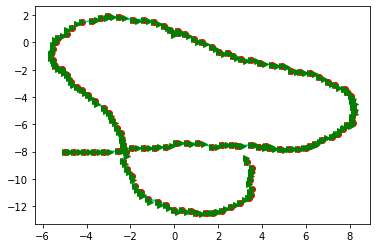

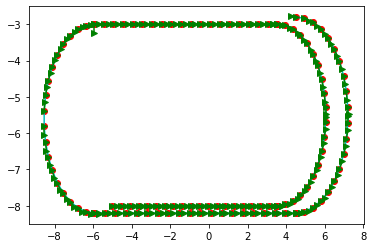

In [84]:
##############################################################################
# TODO: Code for Section 2.1  #

def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (jnp.array(ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))

arr2 = readVertex('./dataset/edges.txt')
del_arr = readEdge('./dataset/edges.txt')
#print(del_arr[2])
iters_odom = 120
iters_loop = 20
    
def motion_model():
    
    f_arr = []
    
    f_arr_x = []
    f_arr_y = []
    f_arr_theta = []
    
    
    x1 = arr2[0]
    y1 = arr2[1]
    theta1 = arr2[2]
    
    for i in range(iters_odom):
        x2 = x1 + (del_arr[2][i] * jnp.cos(theta1)) - (del_arr[3][i] * jnp.sin(theta1))    
        f_arr_x.append(x1)
        
        y2 = y1 + (del_arr[3][i] * jnp.cos(theta1)) + (del_arr[2][i] * jnp.sin(theta1))    
        f_arr_y.append(y1)
    
        theta2 = theta1 + del_arr[4][i]
        f_arr_theta.append(theta1)
        
        #f array -- residual
        f_arr.append(x1)
        f_arr.append(y1)
        f_arr.append(theta1)
        
        x1 = x2
        y1 = y2
        theta1 = theta2
        
    return (jnp.array(f_arr), jnp.array(f_arr_x), jnp.array(f_arr_y), jnp.array(f_arr_theta))

def loop_constraints():
    f_arr_theta_1 = []
    f_arr_x_1 = []
    f_arr_y_1 = []
    f_arr_1 = []
    
    #f_arr_x_1.append(arr2[0])
    #f_arr_y_1.append(arr2[1])
    #f_arr_theta_1.append(arr2[2])
    
    x1 = arr2[0]
    y1 = arr2[1]
    theta1 = arr2[2]
    
    for i in range(iters_odom, iters_odom + iters_loop):
        x2 = x1 + (del_arr[2][i] * jnp.cos(theta1)) - (del_arr[3][i] * jnp.sin(theta1))    
        f_arr_x_1.append(x1)
        
        y2 = y1 + (del_arr[3][i] * jnp.cos(theta1)) + (del_arr[2][i] * jnp.sin(theta1))    
        f_arr_y_1.append(y1)
    
        theta2 = theta1 + del_arr[4][i]
        f_arr_theta_1.append(theta1)
        
        f_arr_1.append(x1)
        f_arr_1.append(y1)
        f_arr_1.append(theta1)

        x1 = x2
        y1 = y2
        theta1 = theta2

    return (jnp.array(f_arr_1), jnp.array(f_arr_x_1), jnp.array(f_arr_y_1), jnp.array(f_arr_theta_1))


def ground_truth():
    arr2_gt = readVertex('./dataset/gt.txt')
    del_arr_gt = readEdge('./dataset/gt.txt')
    draw(arr2_gt[0], arr2_gt[1], arr2_gt[2])
    return (jnp.array(arr2_gt), jnp.array(del_arr_gt))
    
# Plotting trajectory using matplotlib
def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()

a = motion_model()
b = loop_constraints()
f_arr_final = jnp.concatenate((a[0], b[0]), axis=0)
# print(b)
# print(f_arr_final[0])

draw(a[1], a[2], a[3])
op_path = './dataset/edges-poses.g2o'

with open (op_path, 'w') as fp:
    for i in range(len(a[1])):
        fp.write("VERTEX_SE2 {} {} {} {}\n".format(i, float(a[1][i]), float(a[2][i]), float(a[3][i])))
    fp.close()
    
c = ground_truth()
#print(c)
# print(f_arr_final.shape)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

In [90]:
f_res = []
def f_residual_odom(a):
    for i in range(120-1):
        f_res.append(a[1][i+1] - a[1][i])
    f_res.append(a[1][0] - 0)

    for i in range(120-1):
        f_res.append(a[2][i+1] - a[2][i])
    f_res.append(a[2][0] - 0)
    
    for i in range(120-1):
        f_res.append(a[3][i+1] - a[3][i])
    f_res.append(a[3][0] - 0)

def f_residual_loop(b):
    for i in range(19):
        f_res.append(b[1][i+1] - b[1][i])
    f_res.append(b[1][0] - 0)
    
    for i in range(19):
        f_res.append(b[2][i+1] - b[2][i])
    f_res.append(b[2][0] - 0)
    
    for i in range(19):
        f_res.append(b[3][i+1] - b[3][i])
    f_res.append(b[3][0] - 0)

f_residual_odom(a)
f_residual_loop(b)

f_res = jnp.array(f_res)

#------------------------------
#f_res is the final f
#------------------------------

# print(f_res)
print(f_res.shape)
print(a[1].shape)


# from jax.ops import index_update as index_update
# import jax.ops.index as ind

from jax.ops import index, index_update

def jac_analytical(X,Y,Theta):
    J = jnp.zeros((420,360))
    
    #anchor constraints 

    J = index_update(J,index[-3,0],1)
    J = index_update(J,index[-2,1],1)
    J = index_update(J,index[-1,2],1)
    
#     x1 = X[0]
#     y1 = Y[1]
    theta1 = Theta[0]
    
    # for odometry and loop constraints
    for i in range(iters_odom + iters_loop - 1):
        J = index_update(J,index[i*3,i*3],1)
        J = index_update(J,index[i*3+1,i*3+1],1)
        J = index_update(J,index[i*3+2,i*3+2],1)
        
#         f = -(del_arr[2][i] * jnp.sin(theta1)) - (del_arr[3][i] * jnp.cos(theta1))
#         print(f)
        J = index_update(J,index[i*3,i*3+2],*-(del_arr[2][i] * jnp.sin(theta1)) - (del_arr[3][i] * jnp.cos(theta1)))
        J = index_update(J,index[i*3,i*3+3],*-(del_arr[3][i] * jnp.sin(theta1)) + (del_arr[2][i] * jnp.cos(theta1)))

        J = index_update(J,index[i*3,i*3+3],-1)
        J = index_update(J,index[i*3+1,i*3+4],-1)
        J = index_update(J,index[i*3+2,i*3+5],-1)
        
        theta2 = theta1 + del_arr[4][i]
        theta1 = theta2
    return J  
    
def f_x(x):
    i = jnp.arange(iters_odom + iters_loop)
    f = x[i] + (del_arr[2][i] * jnp.cos(f_arr_final[3][i])) - (del_arr[3][i] * jnp.sin(f_arr_final[3][i]))    
    return f

def f_y(y):
    i = jnp.arange(iters_odom + iters_loop)
    f = y[i] + (del_arr[3][i] * jnp.cos(f_arr_final[3][i])) - (del_arr[2][i] * jnp.sin(f_arr_final[2][i]))    
    return f

def f_theta(theta):
    i = jnp.arange(iters_odom + iters_loop)
    f = theta[i] + del_arr[4][i]
    return f

def jac_jax(X,Y,Theta):
    J = jnp.zeros((420,360))
    
    print(i)
    x_ind = jnp.arange(0,120*3,3)
    y_ind = jnp.arange(0+1,120*3,3)
    t_ind = jnp.arange(0+2,120*3,3)
    
    fx = lambda X: f_x(X)   # Now f is just a function of variable to be differentiated
    J_x = jacfwd(fx)(X)

    fy = lambda Y: f_y(Y)   # Now f is just a function of variable to be differentiated
    J_y = jacfwd(fy)(Y)

    f_t = lambda Theta: f_theta(Theta)   # Now f is just a function of variable to be differentiated
    J_t = jacfwd(f_t)(Theta)
    
    J = index_update(J,index[:,x_ind],J_x[:,jnp.arange(0,360)])
    J = index_update(J,index[:,y_ind],J_y[:,jnp.arange(0,360)])
    J = index_update(J,index[:,t_ind],J_t[:,jnp.arange(0,360)])
    
    print(J.shape)

    return J

X = f_arr_final[:,0]
Y = f_arr_final[:,1]
Theta = f_arr_final[:,2]

J_jax = jac_jax(X,Y,Theta)        
    
    

def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")
    


J_an = jac_analytical(X,Y,Theta)    
# print(J_an.shape)
# print(J_an)


# print(s1.shape)
# print(s1)

#Verifying J_jax and J_analytical
frobNorm(J_an, J_jax)


(420, 1)
(120, 1)
119


ValueError: Incompatible shapes for broadcasting: (140, 360) and requested shape (420, 120)

In [66]:

def LM_algo(vertices,info_mat ,no_iter ,tol,lambda_):
    residual = jnp.repeat(0.5,420)
    
    residual_2 = []
    vertices_t = vertices
    
    for i in range(no_iter):
#         J = jac_jax(X,Y,Theta)
        J_r = jac_analytical(vertices_t)
        
        J_F = J_r.T@info_mat@residual
        l_term = lambda_*jnp.eye(360)
#         print((J_r.T@info_mat).shape)
        inv = jnp.linalg.pinv(J_r.T@info_mat@J_r + l_term)
        del_v = -inv@J_F
        print(del_v.shape)
        vertices_t_1 = vertices_t + del_v
        
        error = 0.5*residual.T@info_mat@residual
        
#         res_2 = jnp.linalg.norm(residual,2)
#         residual_2.append(res_2) 
        print("Iteration:{} Error:{}".format(i,error))

#         residual = vertices_t_1 - vertices_t
#         residual = jnp.array(residual).reshape(420,-1)
#         res_2 = jnp.linalg.norm(residual,2)
#         residual_2.append(res_2) 
#         print("Iteration:{} Error:{}".format(i,residual))

        if error < tol:
            for j in range(no_iter - i - 1):
                
                residual_2.append(LA.norm(residual,2)) 
            break
        else:
            vertices_t = vertices_t_1
            
            residual_new = vertices_t_1 - vertices_t
            
            residual_new = jnp.array(residual).reshape(420,-1)
            residual_2_new = jnp.linalg.norm(residual_new,2)
            change = residual_2_new - res_2
            
            if change <= 0:
                lambda_ = lambda_/10
                vertices_t = vertices_t_1
            else:
                lambda_ = lambda_*10
    
# def Gauss_Newton(x ,u ,info_mat ,no_iter ,tol):
# f_x = f(x,u)
# x_t = x
# residual_2 = []

# for i in range(no_iter):
#     print(" ")
#     print("Iteration:{}".format(i))
#     # Isolate the function: variables to be differentiated from the constant parameters
#     f_ = lambda x: f(x,u)   # Now f is just a function of variable to be differentiated

#     J = jacfwd(f_)(x)

#     inv = jnp.linalg.pinv(J.T@info_mat@J)
#     p = (J.T@info_mat.T@f_x)

#     del_x = -inv@p
#     x_t_1 = x_t + del_x
#     print("New x : ",x_t_1)
#     if jnp.max(jnp.abs(x_t_1 - x_t)) < tol:
#         break
#     else:
#         print(("Update in x :{}").format(jnp.max(np.abs(x_t_1 - x_t))))
#         x_t = x_t_1

def Info_mat():
    info_mat = jnp.zeros((420,420))
    for i in range(420):
        if i >=0 and i < (119*3):
            info_mat = index_update(info_mat,index[i,i],20)        #odometry 
        elif i >= (119*3) and i < (119*3 + 20*3):
            info_mat = index_update(info_mat,index[i,i],1000)      #loop closure 
        else:
            info_mat = index_update(info_mat,index[i,i],10000)     #anchor 
    return info_mat

#LM Algorithm
tol = 1e-15 #tolerance
no_iter = 10
lambda_ = 5

print(info_mat[-1,-1])

print(a[1].shape)
info_mat = Info_mat()
LM_algo(a,info_mat ,no_iter ,tol,lambda_)


10000.0
(121, 1)


TypeError: jac_analytical() takes 0 positional arguments but 1 was given

## 2.1 Answer

Give a detailed answer addressing the above questions. When I run the above code, it should follow points described above (such as plots at every 10 steps) and (When I run the above code, it should) write the optimized poses to a file named `opt.g2o`. As a backup, save another file `opt_backup.g2o` in an offline manner beforehand.

That apart, save important plots and add them here so that it can supplement your answer, for example you could add plots at crucial stages of optimization. You have to add useful metrics/plots from `EVO` (refer to supplementary notebook). Using EVO, the bare minimum you have to report is `mean absolute pose error (ape)` and `mean relative pose error (rpe)`. However, you are encouraged to use tools like `evo_traj` and [more](https://github.com/MichaelGrupp/evo/#command-line-interface) and add more plots/metrics. Marks will be awarded based on overall analysis & presentation which would reflect your understanding.

Note that `EVO` and `g2o_viewer` (below) could help you in debugging.

Add answer for 2.1 here:

## 2.2 Using g2o's optimization: g2o binary or g2o viewer 

Installation setup is described in supplementary notebook. More details for 2.2.1 and 2.2.2 can be found in the supplementary notebook.

### 2.2.1 Optimizing `edges.txt`
First task is to optimize the poses of dataset you've been working with so far.

### 2.2.2 Optimizing `intel` and `sphere` datasets
You have been given two datasets in the `data` folder. You have to use `g2o_viewer` to optimize these both. You have to experiment with the options/parameters available in the GUI. More instructions in supplementary notebook. You have to experiment till you get the trajectories which look like the following:

<table><tr>
<td> <img src="./misc/intel.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./misc/sphere.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

## 2.2 Answer

Add images: take screenshot of the GUI of `g2o_viewer` after optimization for all 3 [[CP-M]] and add here. Briefly describe what you had to do (detailed answer is not expected). g2o could potentially give you close to ground truth trajectory for all 3, but if you are unable to get to close to ground truth, add the best you can get.

Ans: <br>
The parameters that we could vary before optimising are the number of iterations and the optimiser (algorithm). Other options like Robust Kernel (that is with robustified (least squares) kernel with different cost functions like Cauchy, Huber, etc and with parameters Non-sequential/Sequential) were also tried but mostly most of them gave a similar answer (same output but slower and faster convergences). Here, we are mentioning the final output with one of the best possible parameters. <br>
Please Note that there is more than one way of getting this output :)

2.2.1 <br>
Optimising Edges.txt <br>
please find the screenshot in the repository named 'edges-g2o-output.jpg' and the end of this cell<br>
Here, the parameters are, <br>
Number of iterations = 10 (they converged very soon :)) <br>
Algorithm used = GN (var_cholmod) <br>
Intial Guess taken = iteration= -1	 chi2= 573824	 time= 0.0	 cumTime= 0.0	 (using initial guess from odometry) <br>
At 10th iteration: iteration= 9	 chi2= 218.290974	 time= 0.000297676	 cumTime= 0.0035603	 edges= 139	 schur= 0 <br>
Here, we used Robust Kernel with Huber loss (Kernel Width = 1.0)<br>

Observations: The convergence didnt change if we didnt choose the robust kernel (Huber loss function) or by increasing the number of iterations, it was same with LM algorithm also. <br>
When we disabled the Robust Kernel, we have the following at the 10th iteration: <br>
iteration= 9	 chi2= 252.492460	 time= 0.000356067	 cumTime= 0.00390262	 edges= 139	 schur= 0 <br>
iteration= 8	 chi2= 252.492460	 time= 0.000278896	 cumTime= 0.00354655	 edges= 139	 schur= 0 <br>
That is, it converged even faster <br>
With increased kernel width, the convergence is faster with the Robust Kernel
We did not get exactly or much similar to the provided ground truth. Find the gt-poses image at the end of the cell. <br>


2.2.2 (a) Intel <br> <br>
Optimising intel.g2o <br>
from ref https://www.cct.lsu.edu/~kzhang/papers/g2o.pdf <br>
Intel has --> 943 poses and 1837 constraints and no landmarks <br>

Here, the parameters are, <br>
Number of iterations = 50  <br>
Algorithm used = GN (var_cholmod) <br>
Intial Guess taken = iteration= -1	 chi2= 5.1497e+06	 time= 0.0	 cumTime= 0.0	 (using initial guess from odometry) <br>
At 50th iteration: iteration= 49	 chi2= 215.830235	 time= 0.0024787	 cumTime= 0.146164	 edges= 1483	 schur= 0 <br>
Here, we disabled robust kernel <br>

Observations: The convergence changed a bit if we choose the robust kernel (Huber loss function, kernel width 10 and 100) and by increasing the number of iterations and LM algorithm. Please look at the images for parameter details <br>

When Robust Kernel (KW = 10.0), we have the following at the 50th iteration: <br>
iteration= 48	 chi2= 215.830235	 time= 0.00224822	 cumTime= 0.130088	 edges= 1483	 schur= 0 <br>
iteration= 49	 chi2= 215.830235	 time= 0.00233768	 cumTime= 0.132425	 edges= 1483	 schur= 0 <br>
That is, it converged almost in same speed. <br>

2.2.2 (b) Sphere <br> <br>
Optimising sphere.g2o <br>
This dataset was large so convergence was slow overall comparatively (large dataset) <br>
from ref https://www.cct.lsu.edu/~kzhang/papers/g2o.pdf <br>
Sphere has --> 2500 poses and 4949 constraints and no landmarks

Here, the parameters are, <br>
Number of iterations = 500 <br>
Algorithm used = GN (var_cholmod) <br>
Intial Guess taken =  iteration= -1	 chi2= 1.76631e+08	 time= 0.0	 cumTime= 0.0	 (using initial guess from odometry) <br>
At 500th iteration:  iteration= 499	 chi2= 919404.135925	 time= 0.356311	 cumTime= 117.475	 edges= 8647	 schur= 0 <br>
Here, we disabled robust kernel <br>

Observations: The convergence didnt change if we choose the robust kernel (Cauchy loss function), it was same with LM algorithm also. <br>

With no Robust Kernel, we have the following at the 50th iteration: <br>
iteration= 48	 chi2= 936425.508250	 time= 0.236079	 cumTime= 11.2007	 edges= 8647	 schur= 0 <br>
iteration= 49	 chi2= 935824.107106	 time= 0.226384	 cumTime= 11.4271	 edges= 8647	 schur= 0 <br>

At 100th iteration: <br>
iteration= 98	 chi2= 931007.611625	 time= 0.23154	 cumTime= 22.9712	 edges= 8647	 schur= 0 <br>
iteration= 99	 chi2= 931435.587899	 time= 0.224933	 cumTime= 23.1961	 edges= 8647	 schur= 0 <br>
That is, it converged almost in same speed. <br>

Here, as we increases number of iterations, the sphere was turining from an ellipsoid like shape to a perfect sphere slowly. Finally we got a distorted sphere at 500 iteratinons with GN algo and no robust kernel

With robust kernel and the following parameters, we got better sphere in 70 iterations  <br>
Huber loss, Robust kernel, Kernel width = 10.0, LM (var_cholmod) algorithm

iteration= 70	 chi2= 712609.307612	 time= 2.27012	 cumTime= 22.4827	 edges= 8647	 schur= 0	 lambda= 1474153325.367473	 levenbergIter= 10

Overall, we found that robust kernel is better for larger datasets. <br>
Please note, we have showed images with CHOLMOD as the linear solver. The results were a bit distorted and not perfect with the others. <br>

Please note we have inserted the images of ouputs which made some difference, otherwised we tweaked around all the available ones :) <br>

Question 2.2.1 edges images <br>

Ground Truth <br>
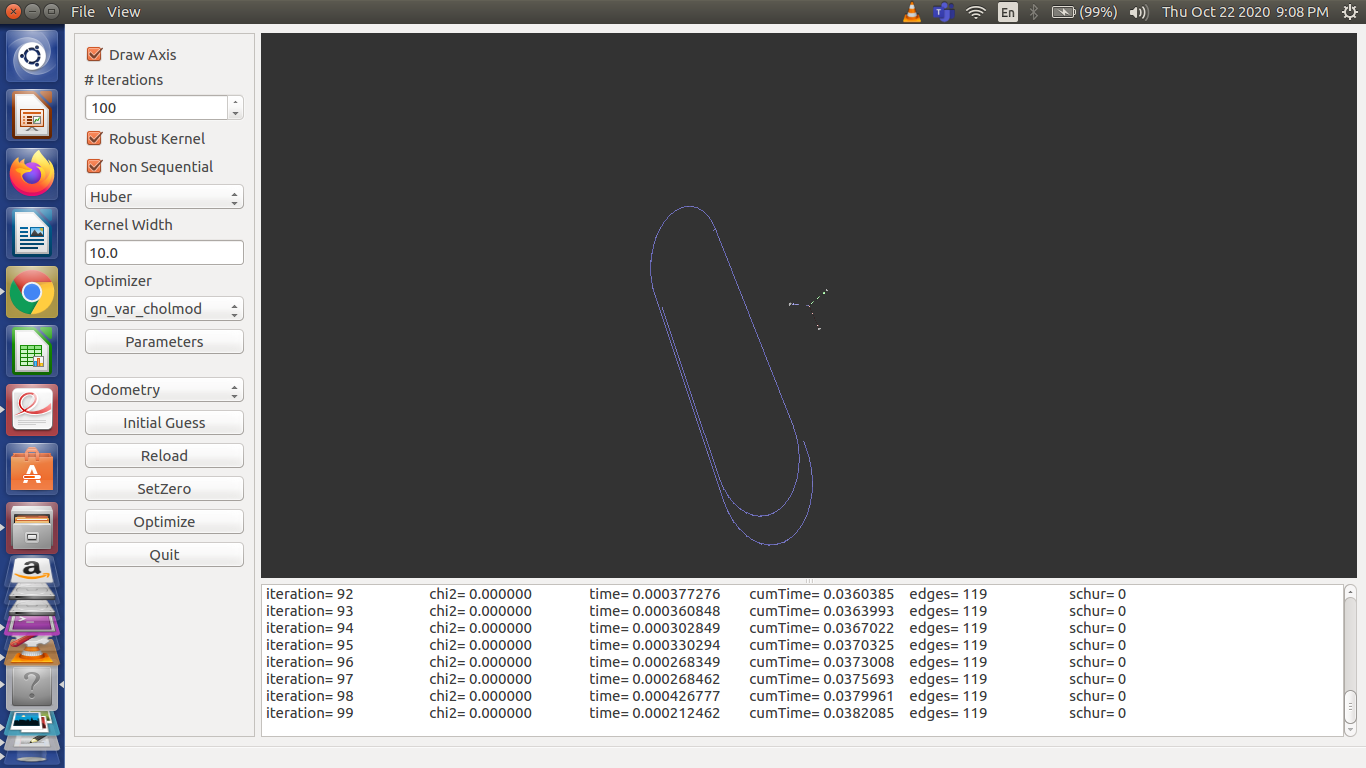 <br>

Edges.txt - final good ouput <br>

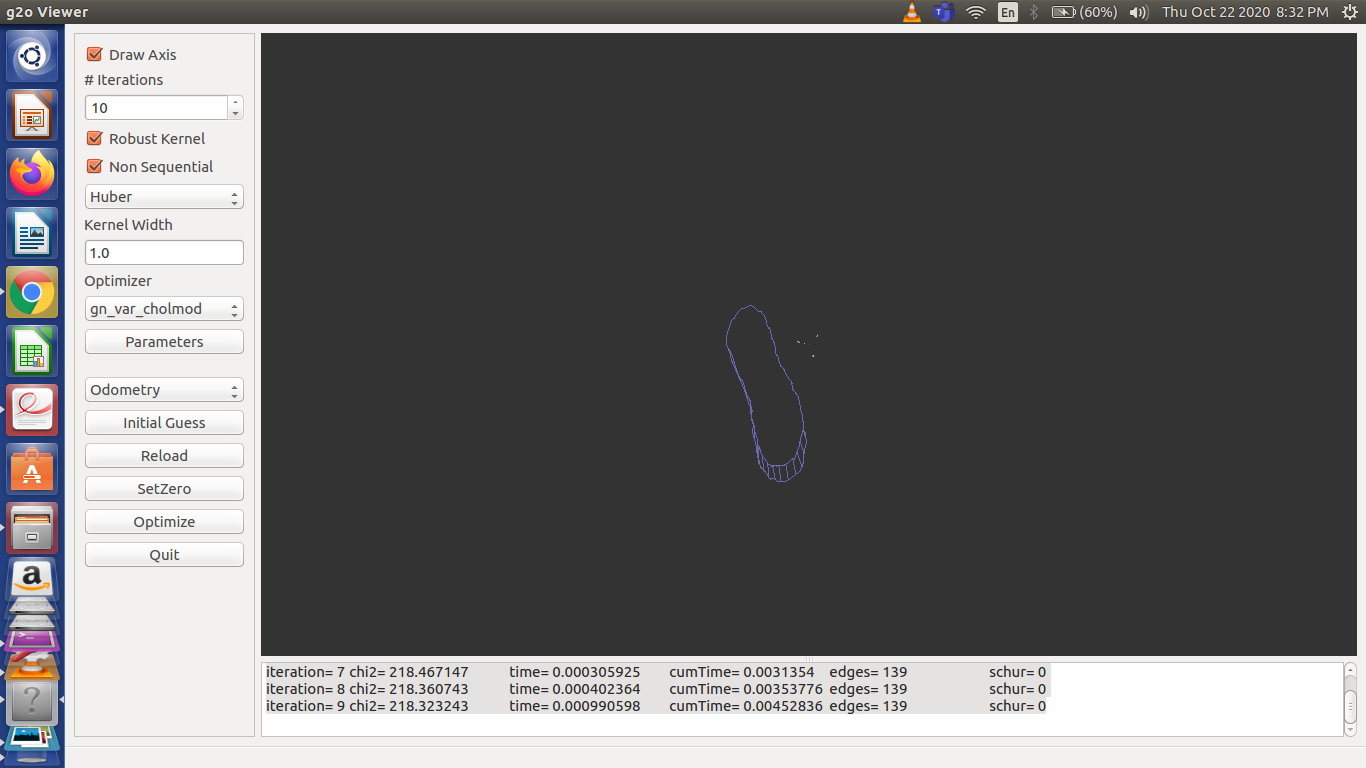 <br>
 
Question 2.2.2 (a) intel images <br>

GN No robust kernel - final good ouput <br>

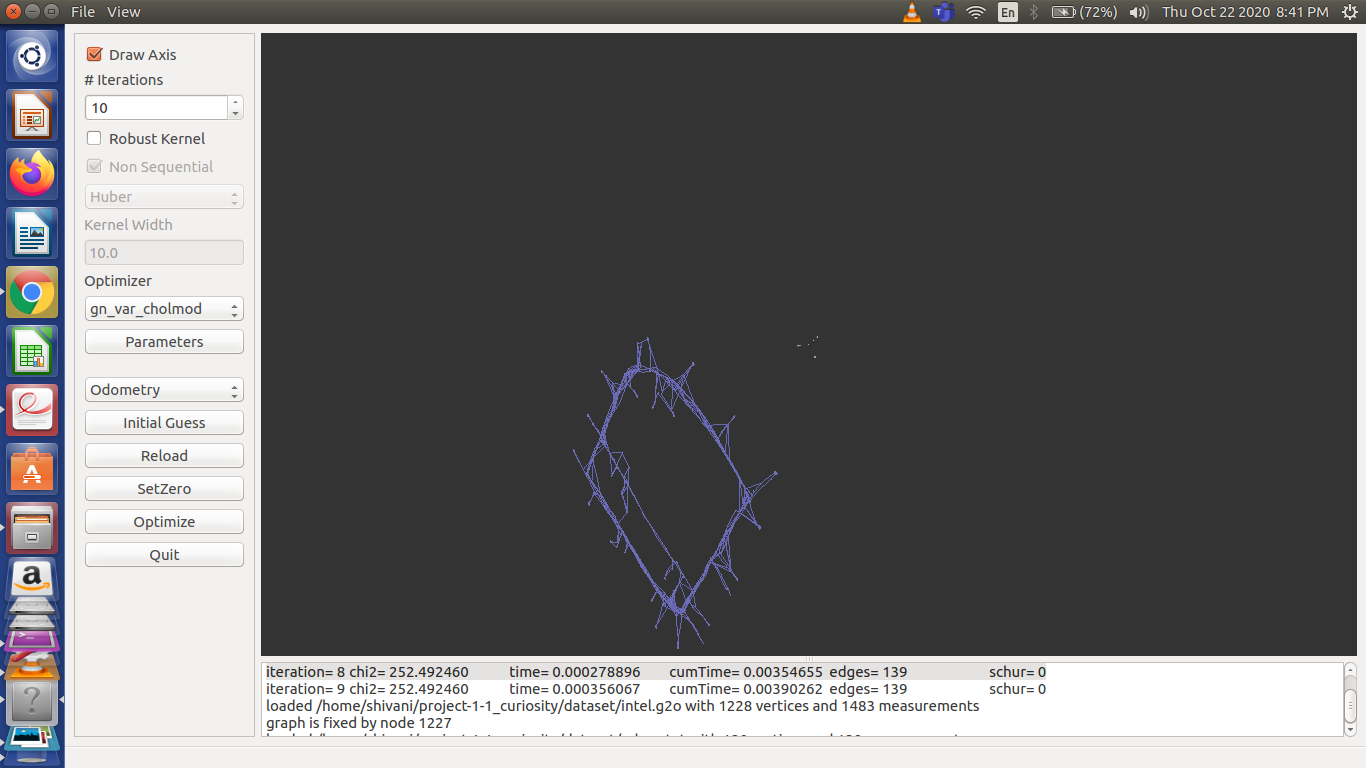 <br>

LM Robust Kernel Huber Loss KW = 100 <br>

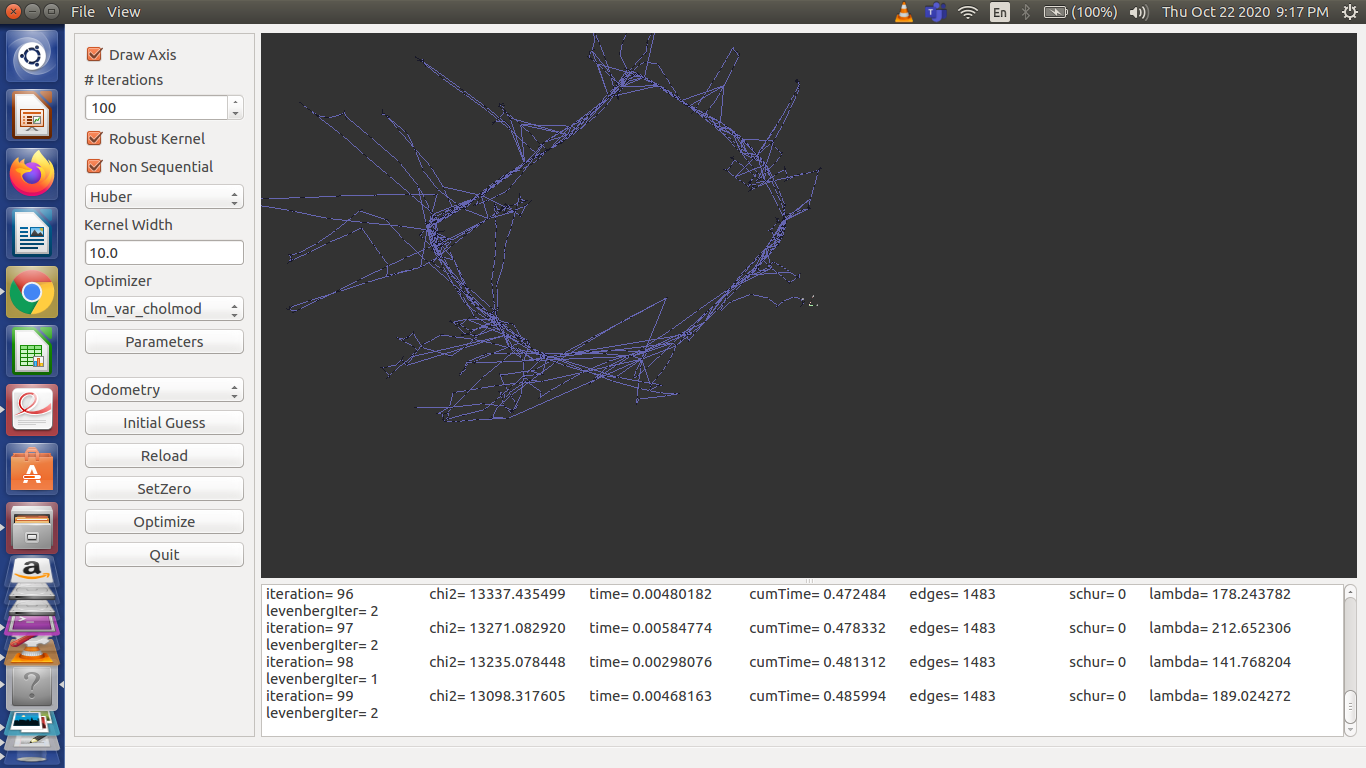 <br>

LM Robust Kernel Huber Loss KW = 10 <br>

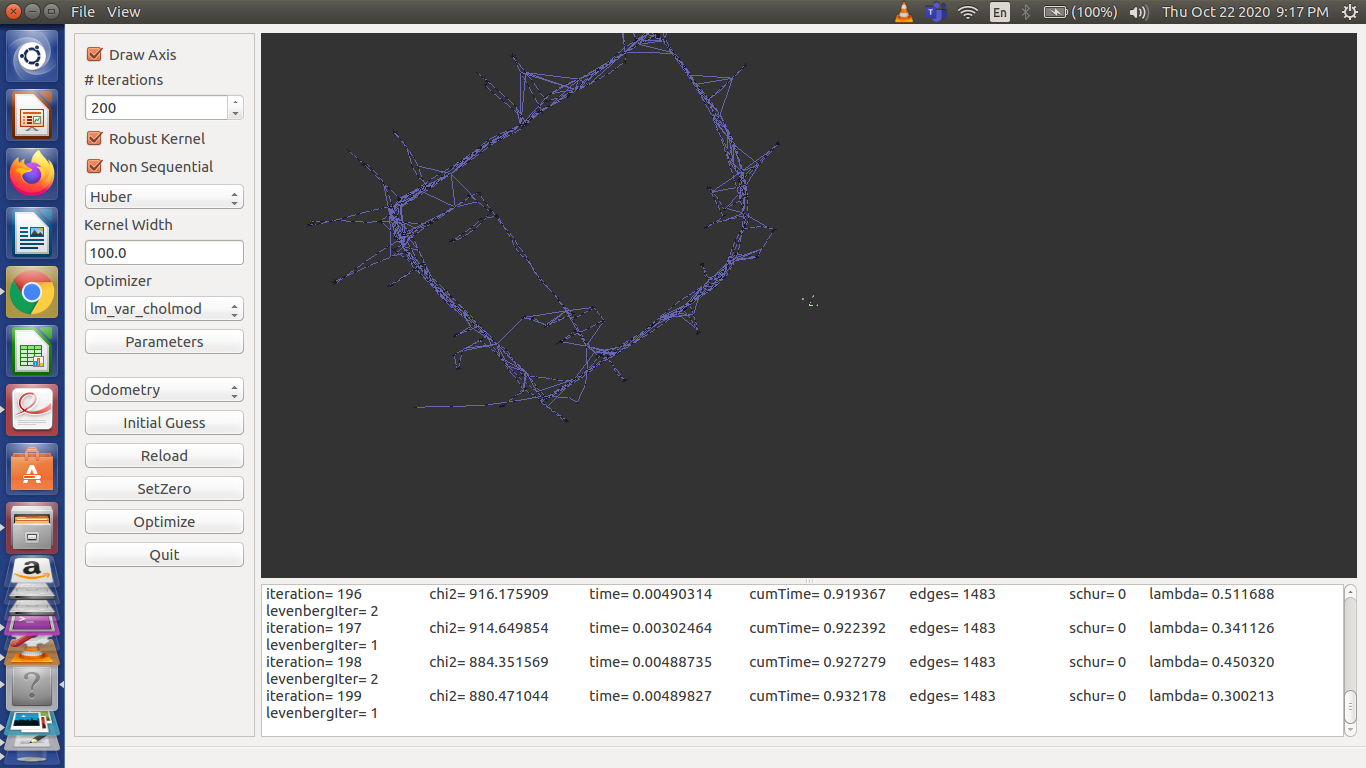 <br>

Question 2.2.2 (b) sphere images <br>

GN 50 iters <br>

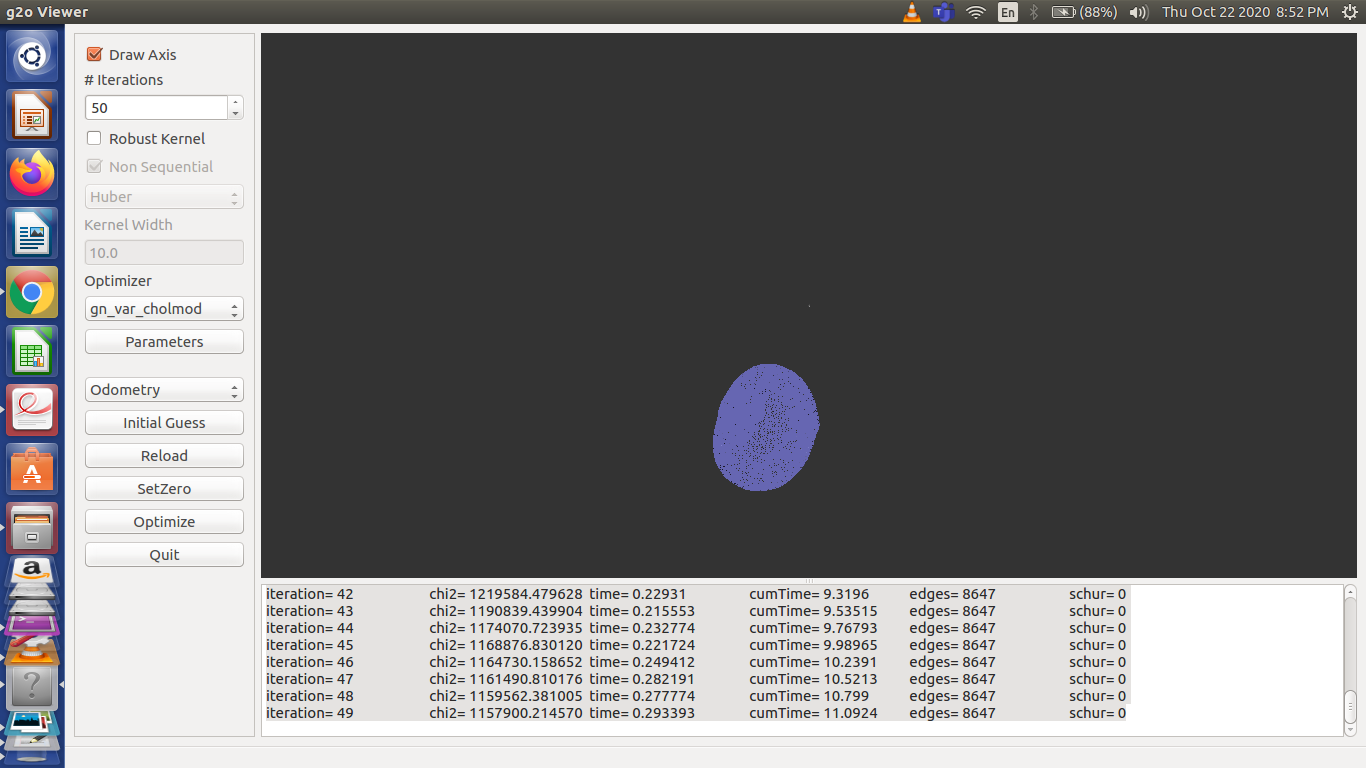 <br>

GN 100 iters <br>

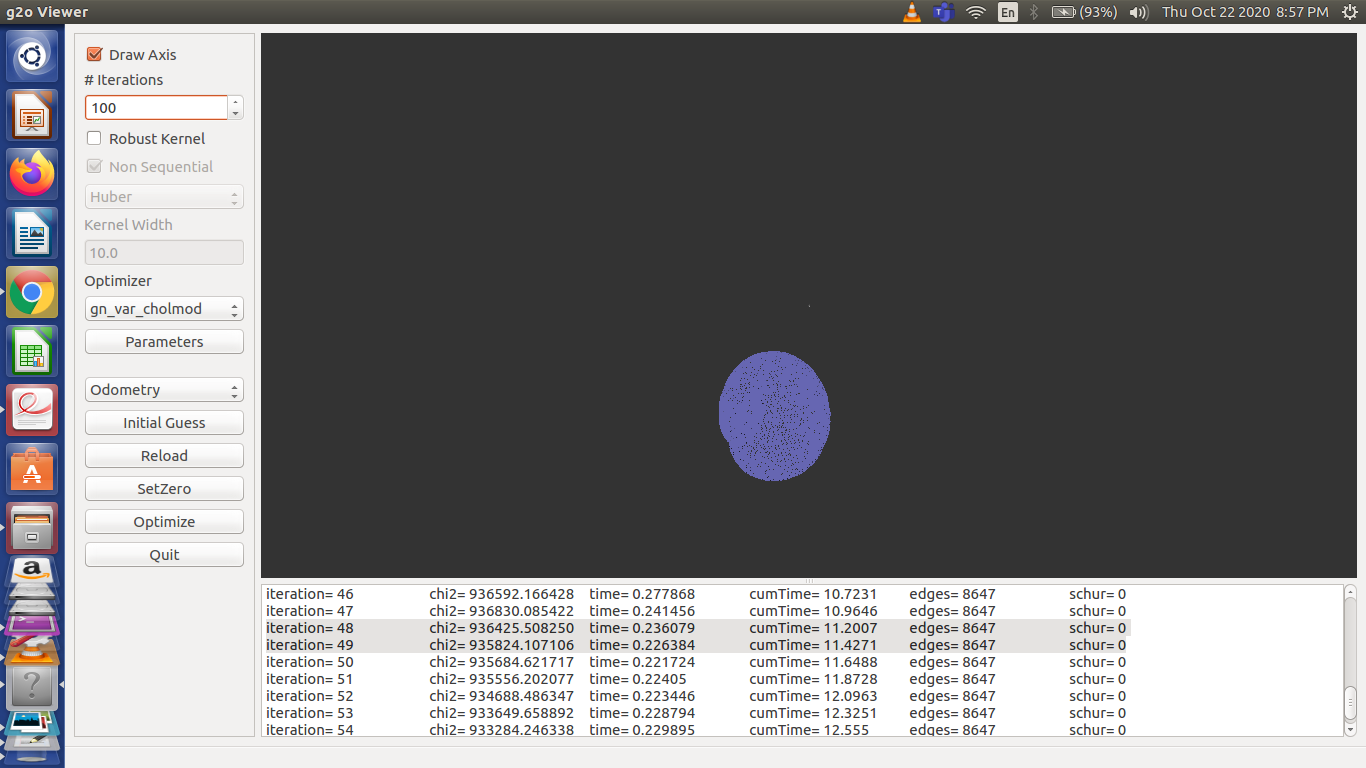 <br>

GN 200 iters <br>

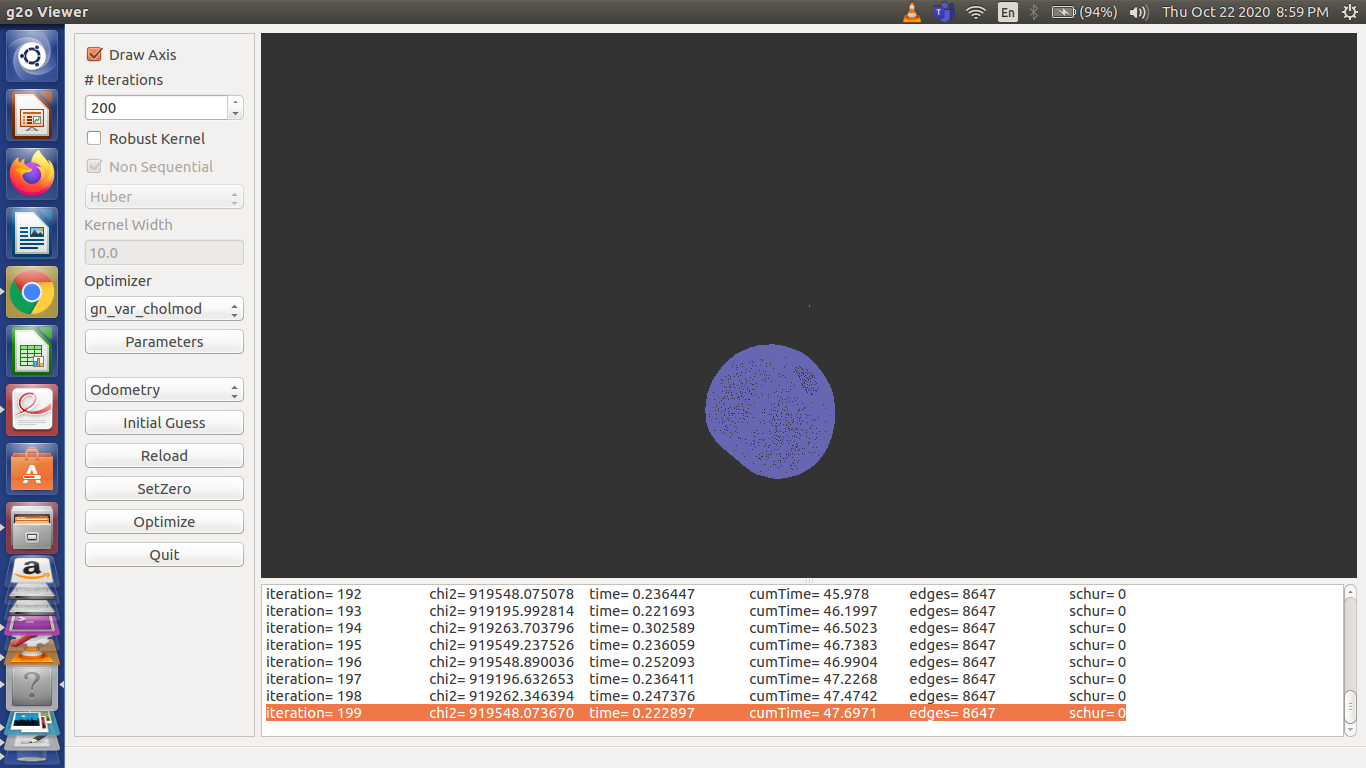 <br>

LM Huber cost Function max 100 iters (converged at 70) - final good output <br>

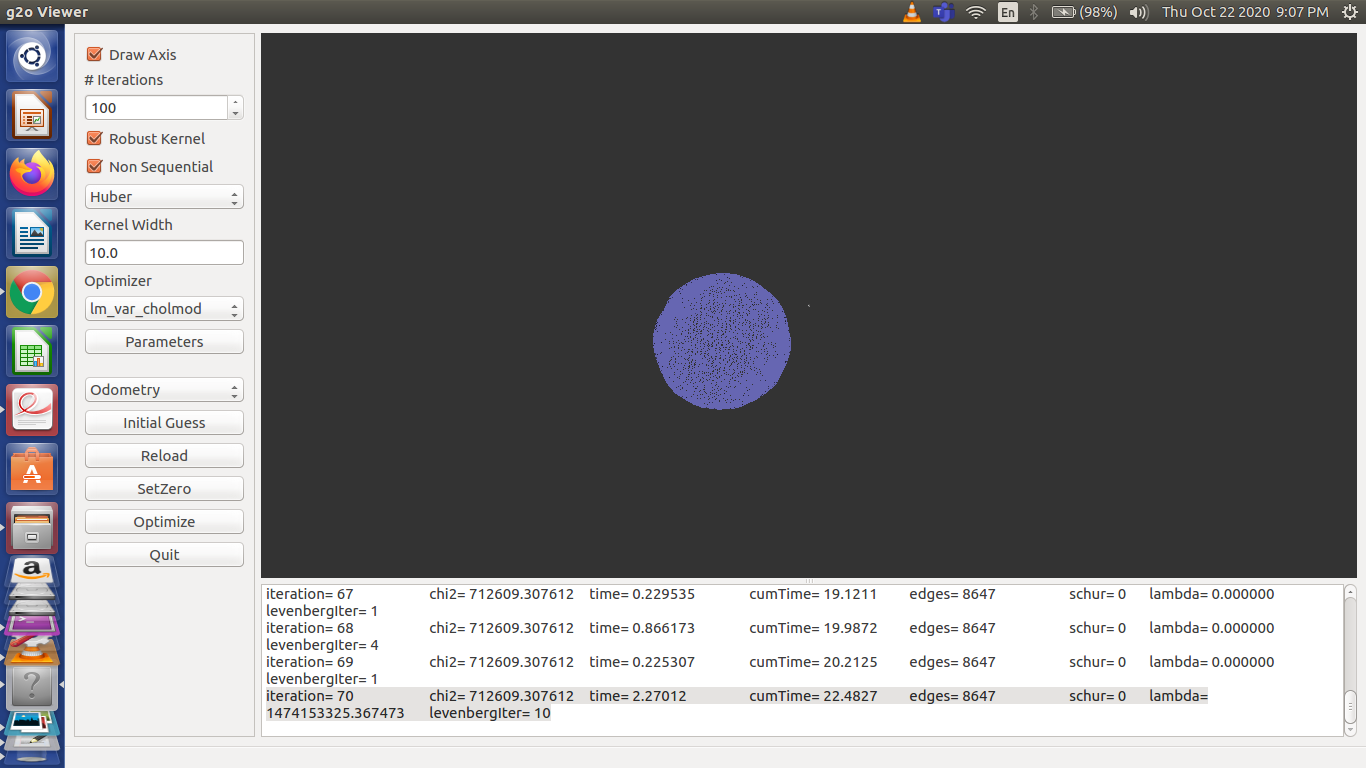

###  * Important Information regarding Questions 3  & 4
Note that it is mandatory to attempt EITHER 3 OR 4, only one of it. If you attempt both, the question which you score more will be considered and the other as bonus question. 

It is encouraged for those into robotics/deep learning research to prefer 4 over 3.

# [Bonus*] 3. Deriving Motion model geometrically
\* -> read information above under section "Important Information regarding Questions 3  & 4"

 
The current robot state is as follows: ($i$ and $k$ are interchangably used below, sorry I am too lazy to edit now 😛)  
![robot-situation.png](./misc/robot-situation.png)

Can you derive the below equation using geometry? (Read on)

$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

In other words, we want to find $\delta$'s in terms of $\Delta$'s
$$\delta x = \Delta x \cos(\theta) - \Delta y \sin(\theta) \\
\delta y = \Delta y \cos(\theta) + \Delta x \sin(\theta) \tag{2}$$

where $\delta$'s are the updates in our motion model equation:
$$ x_{k+1} = x_{k} + \delta x \\
y_{k + 1} = y_k + \delta y \\
\theta_{k+1} = \theta_{k} + \delta \theta \tag{1}$$

Oh yes, $\theta$ is straightforward, i.e. $\delta \theta = \Delta \theta$ but why? 

Using geometry, you could just draw and insert a self-explanatory image as the answer to this question.

If you can derive it without using geometry purely using transform matrices/algebra, that is fine too. Whatever you're comfortable.

## 3. Answer
![block.jpg](./misc/block.jpg)

From the above diagram , the initial pose of the robot is $ (x_{k}, y_{k},\theta_{k}) $ and the next position is $ (x_{k+1}, y_{k+1},\theta_{k+1}) $ .

$ (\Delta x,\Delta y,\Delta \theta) $ are updates measured by the robot's odometry whereas $ (\delta x,\delta y,\delta \theta) $ are updates by true incremental odometry.

The term $ \left[\begin{array}{cccc}\cos\theta_{k} & -\sin\theta_{k} & 0 \\ \sin\theta_{k} & \cos\theta_{k} & 0  \\0 & 0 & 1 \end{array}\right] $ is a rotation matrix that accounts for the rotation of the robot

$\left[\begin{array}{c}x_{k+1}\\ y_{k+1}\\ \theta_{k+1}\end{array}\right] = \left[\begin{array}{c}x_{k}\\ y_{k}\\ \theta_{k}\end{array}\right] + \left[\begin{array}{cccc}\cos\theta_{k} & -\sin\theta_{k} & 0 \\ \sin\theta_{k} & \cos\theta_{k} & 0  \\0 & 0 & 1 \end{array}\right] \left[\begin{array}{c}\Delta x\\ \Delta y\\ \Delta \theta\end{array}\right]$

$\left[\begin{array}{c}x_{k+1} - x_{k}\\ y_{k+1}- y_{k}\\ \theta_{k+1}-\theta_{k}\end{array}\right] = \left[\begin{array}{cccc}\cos\theta_{k} & -\sin\theta_{k} & 0 \\ \sin\theta_{k} & \cos\theta_{k} & 0  \\0 & 0 & 1 \end{array}\right] \left[\begin{array}{c}\Delta x\\ \Delta y\\ \Delta \theta\end{array}\right]$

$\left[\begin{array}{c}\delta x\\ \delta y\\ \delta \theta\end{array}\right] = \left[\begin{array}{cccc}\cos\theta_{k} & -\sin\theta_{k} & 0 \\ \sin\theta_{k} & \cos\theta_{k} & 0  \\0 & 0 & 1 \end{array}\right] \left[\begin{array}{c}\Delta x\\ \Delta y\\ \Delta \theta\end{array}\right]$

Finding $\delta$'s in terms of $\Delta$'s
$$\delta x = \Delta x \cos(\theta) - \Delta y \sin(\theta) \\
\delta y = \Delta y \cos(\theta) + \Delta x \sin(\theta) \\
\delta \theta = \Delta \theta $$

$\delta$'s are the updates in the motion model equation
$$ x_{k+1} = x_{k} + \delta x \\
y_{k + 1} = y_k + \delta y \\
\theta_{k+1} = \theta_{k} + \delta \theta $$

$ \delta \theta = \Delta \theta $ is the same since it is independent of other changes and the difference in $\theta $ is due to true incremental odometry $(\delta \theta) $ and the measured value $(\Delta \theta) $ will be same. The rotation parameter $(\theta)$ are independent unlike translation parameters (x and y) which are depedendant on rotation parameters.

# [Bonus*] 4. Research Paper Reading
\* -> read information above under section "Important Information regarding Questions 3  & 4"

(Do not get intimidated, you are not expected to do a thorough research analysis for this task. A high level understanding is sufficient.)


["Past, Present & Future of SLAM: Towards the Robust Perception Age"](https://arxiv.org/abs/1606.05830) is an exciting survey paper of 2016 which sums up, well, the "past, present & future" of SLAM. Your task is as follows:

1. Go through the sections "IV. LONG-TERM AUTONOMY II: SCALABILITY" & "III. LONG-TERM AUTONOMY I: ROBUSTNESS". Don't worry, you are not expected to have a deep understanding. Skip the parts which you don't understand at all. Go through it at a high level, and take a slightly closer look at "Open Problems" in these sections.

2. Read up common applications of deep learning for computer vision/robotics through blogs online (for example, first 4 points of [this](https://machinelearningmastery.com/applications-of-deep-learning-for-computer-vision/). Again, you are only expected to understand it at a high level, for example, 'semantic segmentation is an application of deep learning for computer vision which is the task of assigning a category to each of the pixels in the image'.

Firstly, summarize your understanding of the above two points.
   
Now, from the understanding you've gathered so far, how would you approach solving those "Open Problems"? 
Can these algorithms help in dealing with some of the issues you might have faced during this project? Can the deep learing based high level understanding of the world help in SLAM? In the context of long term autonomy, imagine tomorrow's world with a buddy robot R2-D2 which follows you wherever you go... Now imagine how easily the trajectory can diverge, how big the map could soon become and how the computation could easily become intractable.   

Answer the above questions in the context of this project and those 2 sections of the survey paper.

## 4. Answer


1. The paper describes about the SLAM algorithm in detail exploring its various improvements and vulnerabilities throughout the years. It deeply discusses about the robustness and scalability aspects of SLAM considering it as a long term autonoumous system along with potential problems of the current SLAM systems. 

* **ROBUSTNESS**
    * Various challenging situations faced by existing SLAM systems while performing in reality along with some  possible solutions to increase robustness in highly dynamic environment was discussed. Current SLAM algorithms have various limitations affecting the entire robustness of the system, arising from both hardware and algorithmic failures. The front end of SLAM which is usually responsible for data collection can send erroneous data to the back-end due to sensor degradation. There can also be data association problems in two ways either by perceptual aliasing which produces false positives or by creating fewer measurements by rejected samples due to false negatives.
    * SLAM assumes a static environment with no dynamics, this creates additional challenges when SLAM tries to work in an unconstrained environment especially with long term data association. Dynamic environments have to be incorporated into SLAM models with time dependent parameterisation. Loop closure detection problem for long term SLAM is solved by using Bag of Words which enables better modelling and quantisation of the environment. Computer vision based methods with RANSAC are also used for detecting outliers. In case of not detecting incorrect loop closures in the front end, the back-end of the SLAM can be made better by using optimisation with the help of residual errors

* **SCALABILITY**
    * Operating in highly large scale environments over longer durations could pose challenges to the existing SLAM systems. Robots performing in such conditions require higher computational power and memory since the size of the graph to be optimised becomes increasingly dense with larger number of nodes. To solve these issues, sparsification methods were proposed by ensuring addition of nonredundant nodes to the graph along with introduction of new constraints between existing nodes. 
    * A distributed parallelising mechanism was created either by division of the factor graph across multiple processors or by deployment of many robots for performing sub-tasks. For multi-robot systems, subgraphs were either centralised or decentralised to perform mapping of a large-scale location. It was also ensured to create dense representations for data transfer among multiple robots to reduce communication cost.

2. Some common deep learning applications in computer vision and robotics include object detection , image classification with localisation, object segmentation and so on are based on learning by training deep networks with large datasets. This can be applied to the robotics domain such as for self driving cars which rely on Deep Learning to train the model for which has better performance and accuracy compared to those developed by standard robotics algorithms. Image segmentation is a common application with various types semantic and instance segmentation, object detection with bounding boxes is another application in computer vision.

### **Solving Open Problems**

* SLAM systems have to be robust and resilient to hardware failures that may occur due to sensor degradation which introduces noise in the data captured by the front-end system and this may lead to extreme issues in the back-end. Therefore, SLAM back-end should be developed with **noise models** such that it can withstand great amount of noise, and optimisation algorithms like **Gauss Newton** can be used which have high resistance to noise. Deep Learning models can trained on data obtained through human supervision, thus the robots will learn to mimic human behaviour in various situations (eg: training self driving cars with human driver data) and SLAM systems can be made more robust to noise by training on challenging environments with noisy data. Even **reinforcement learning** models could be used in highly dynamic environments since they can constantly adapt to changes. 

* Deep Learning with the help of **object detection and segmentation to capture and classify objects in moving or stationary could help in a better modelling of SLAM with dynamic environment** in consideration compared to the previous static world assumption. **Segmentation into moving objects and simulating their motion models** can help predict a better path for the robot. **Training data can model real world scenarios** and this can make the SLAM system performance better. 

* Depth estimation through both images and sensors can be used which can help incase of hardware failure or fusion of data from different sensors can be used which increases the reliablity of SLAM sytems. Computer vision based techniques like **non-rigid SfM** can be used to model dynamic environments. Dynamic SLAM methods can be used which can predict moving objects segment them, assign semantic labels and bounding boxes(or masks) of the objects. Deep Learning models like Mask R-CNN can be used, obtaining better segmentation of the surrounding environment. Using semantic labels, we can establish that some pixels corresponding to a particular object. We can then develop a 3d reconstruction model of the all moving objects and track them individually.

* Compressed ways of storing map representations with the help of cloud storage systems is highly beneficial for resource constrained SLAM systems. **Automatic parameter tuning** can help in attaining lesser error and faster convergence, with respect to the project we had to experiment heavily and vary parameters to find the best value, SLAM can become better if this can be automated.

* **Multi-robot SLAM systems** can be used with subgraphs to perform mapping of a large-scale location. Integration of these subgraphs by learning features with deep learning can create better representations/ maps. These representations can be more compact than maps created by conventional methods and can be used across a large number of agents.

* To reduce data storage requirement, we can take incomplete partial scans of the environment and use deep learning to predict the complete 3D model with semantic labels enabling better SLAM. Therefore, by just using sparse map of the environment we can establish the entire voxelised representation of the environment.

* New SLAM sytems like the LSD-SLAM (Large Scale Direct Monocular SLAM) can perform efficiently even on a large scale. With the help of deep learning, now we can predict **depth maps even from a single image** by using CNNs , this has been used in combination with monocular SLAM in CNN-SLAM to obtain better results.


Thus, incorporating Deep Learning into SLAM will definitely help in developing long term autonomous SLAM based systems.


### Fun section
Check the end of your Project-1 homepage on Notion. :)